## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

(720, 1280, 3)


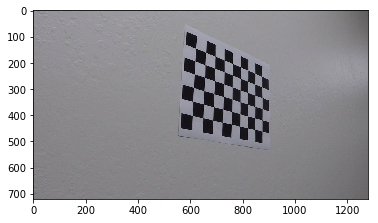

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline
#Read an image 
img = mpimg.imread('camera_cal/calibration9.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

In [2]:
# rows observed in image in x direction : 9 ;;; columns observed in image in y direction : 6 
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 

In [2]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)


In [3]:
#Apply a distortion correction to raw images.

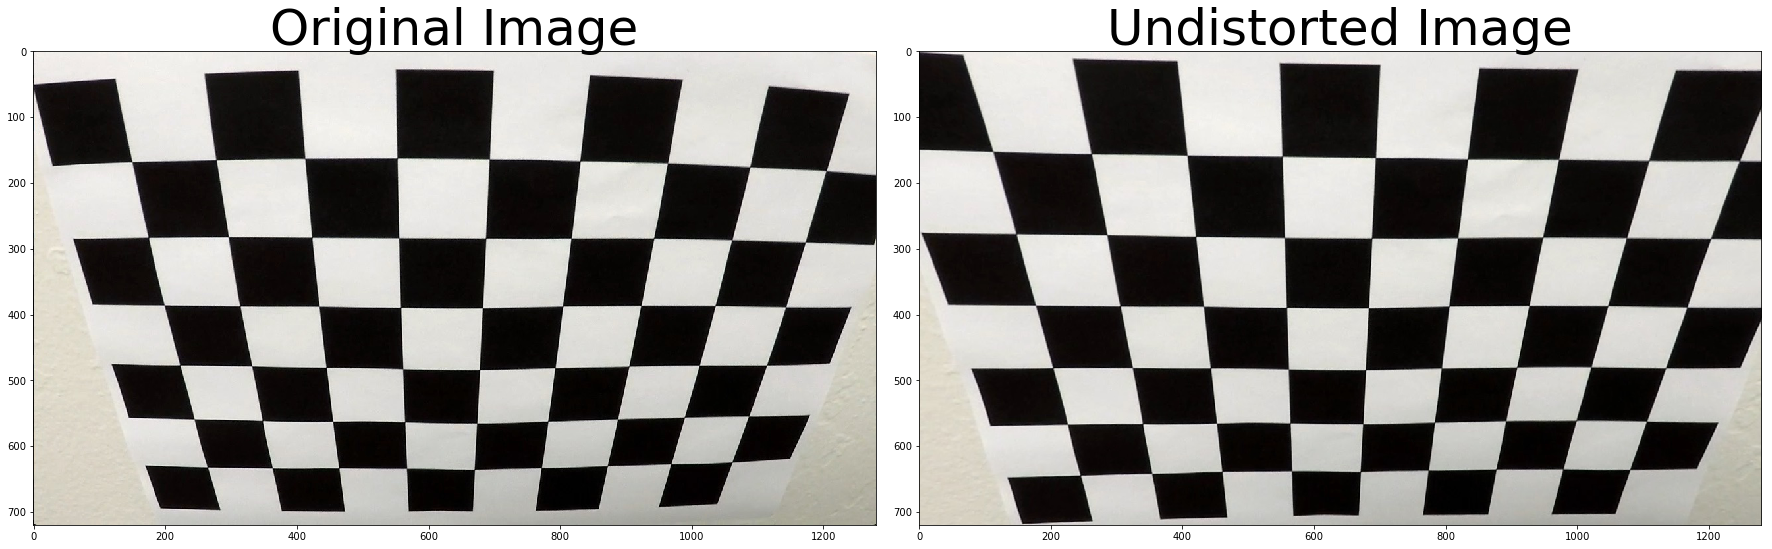

In [6]:
img = mpimg.imread('camera_cal/calibration2.jpg')
# Undistort the image(s) using function below 
undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

In [12]:
import os
out_dir = 'output_images/'
for fname in fnames:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    image_name = os.path.split(fname)[1]
    write_name = out_dir + 'undistorted_' + image_name
    cv2.imwrite(write_name, dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/undistorted_calibration5.jpg
output_images/undistorted_calibration4.jpg
output_images/undistorted_calibration6.jpg
output_images/undistorted_calibration7.jpg
output_images/undistorted_calibration3.jpg
output_images/undistorted_calibration2.jpg
output_images/undistorted_calibration1.jpg
output_images/undistorted_calibration20.jpg
output_images/undistorted_calibration19.jpg
output_images/undistorted_calibration18.jpg
output_images/undistorted_calibration15.jpg
output_images/undistorted_calibration14.jpg
output_images/undistorted_calibration16.jpg
output_images/undistorted_calibration17.jpg
output_images/undistorted_calibration13.jpg
output_images/undistorted_calibration12.jpg
output_images/undistorted_calibration10.jpg
output_images/undistorted_calibration11.jpg
output_images/undistorted_calibration9.jpg
output_images/undistorted_calibration8.jpg


In [ ]:
# All images are calibrated , corrected for distortion coefficients and saved in output_images folder

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("function for masking region of interest")

function for masking region of interest


In [8]:
# Calculate directional gradient
# same as example https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/0bcd97c5-66f3-495b-9fe2-3f9f541bae25/concepts/ac652b00-7257-4c90-8087-eda8f152a035
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
#same as example : https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/0bcd97c5-66f3-495b-9fe2-3f9f541bae25/concepts/78be8208-1af0-4cb4-8a60-2d904b696449
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

print("Functions for edge dections are created")

Functions for edge dections are created


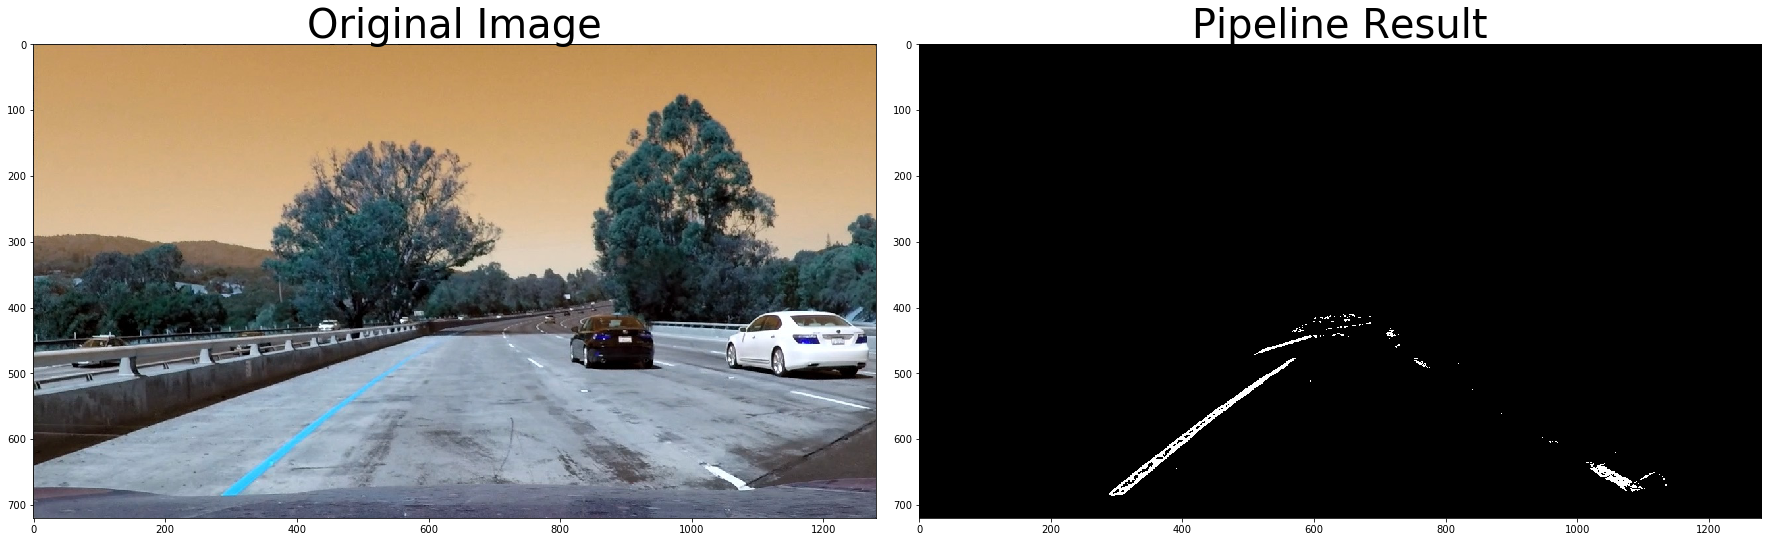

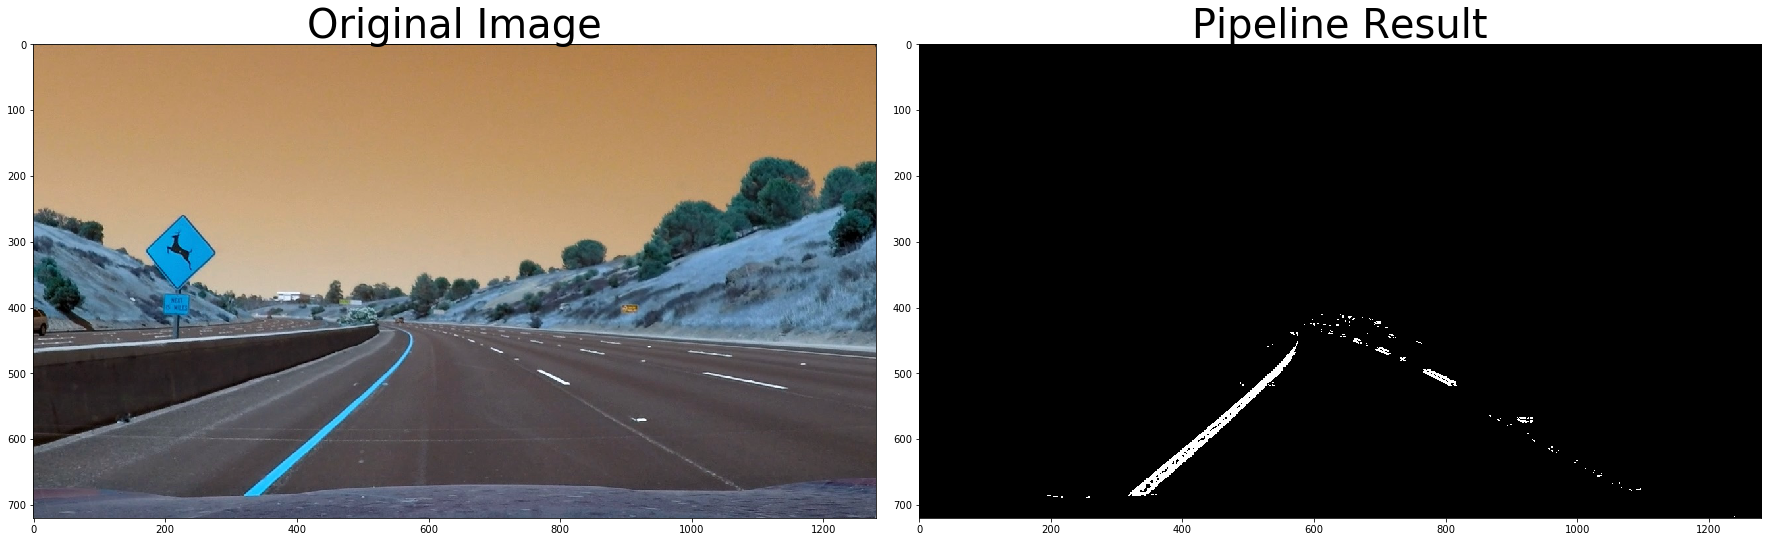

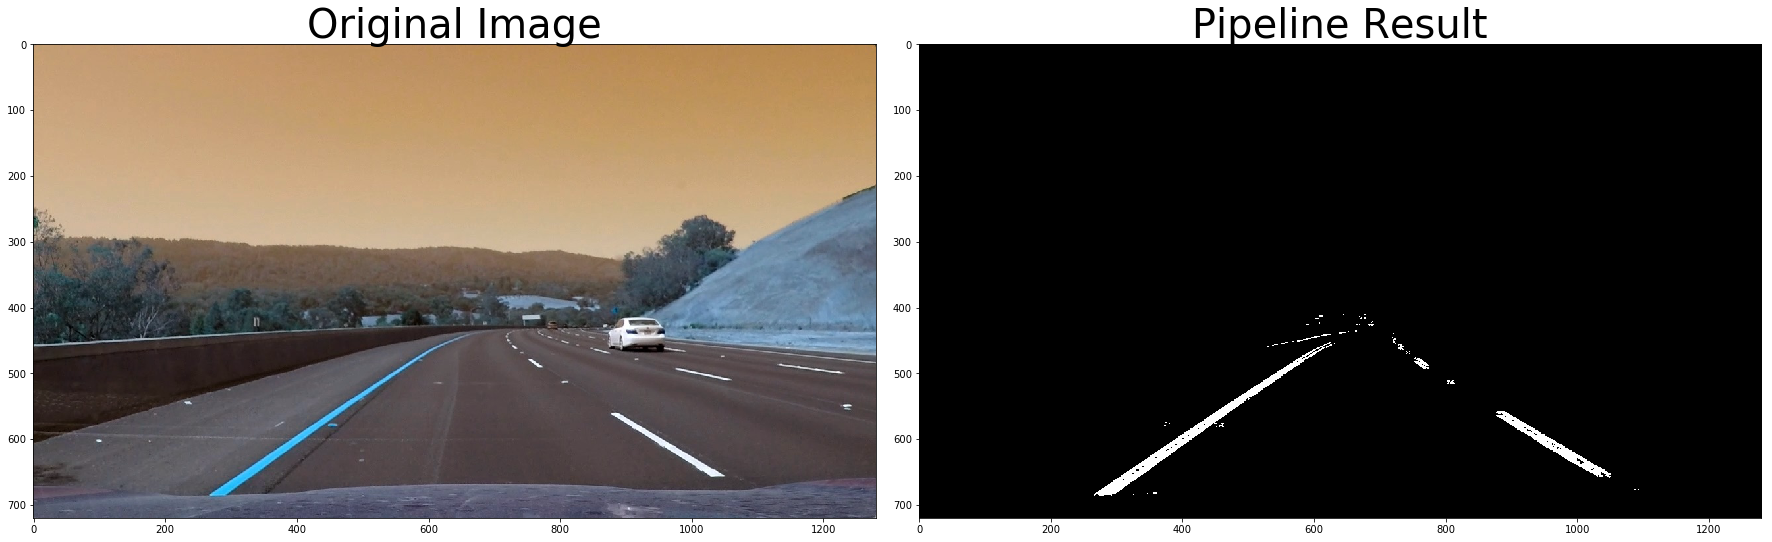

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


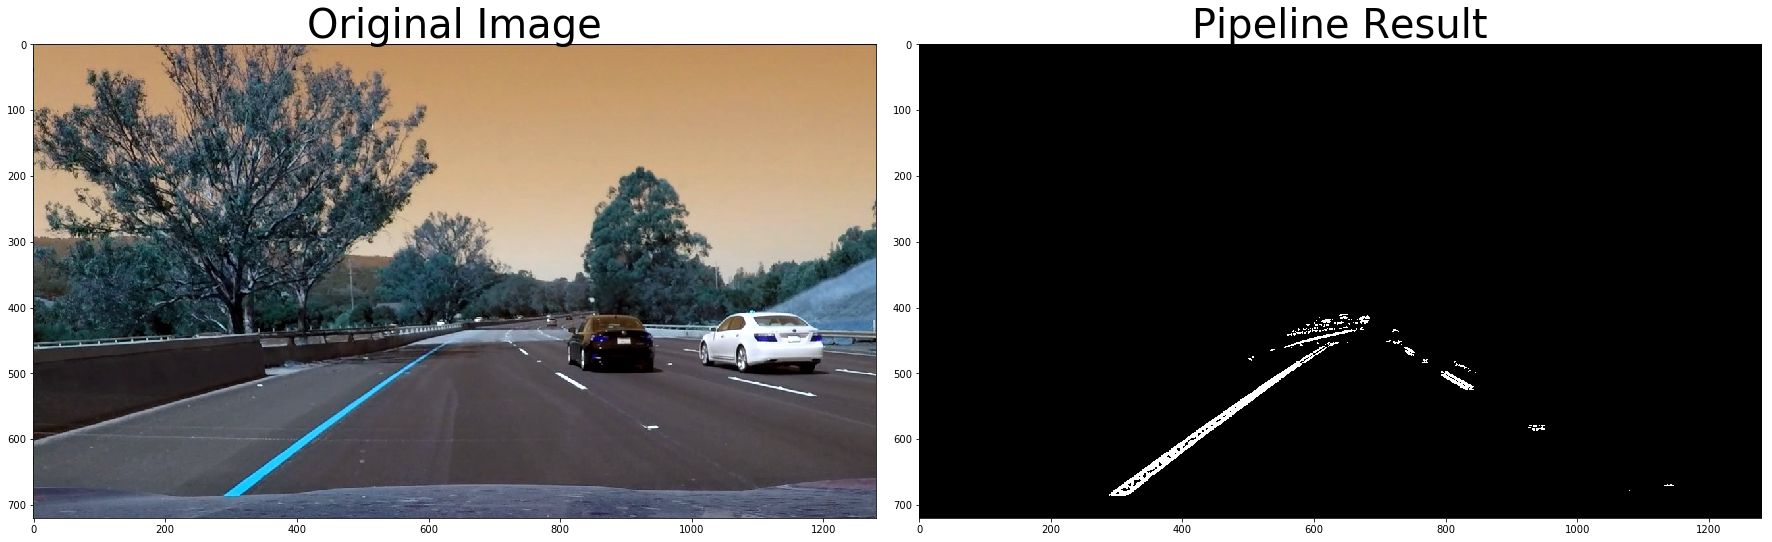

In [9]:
# Edit this function to create your own pipeline.
import time
def pipeline(img):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary
    
for i in range(1,7):
    time.sleep(5)     
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    result = pipeline(image)
 
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Apply a perspective transform to rectify binary image ("birds-eye view").

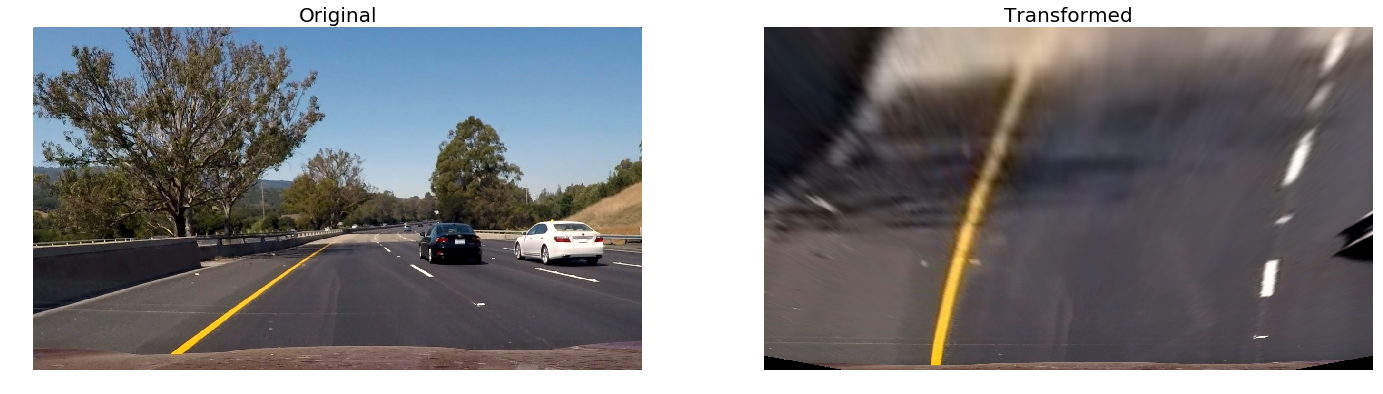

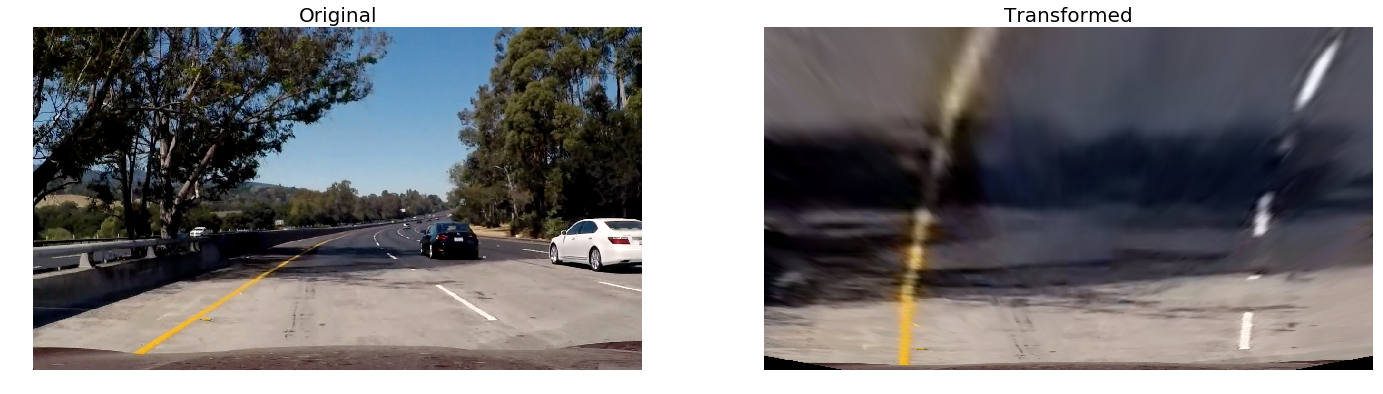

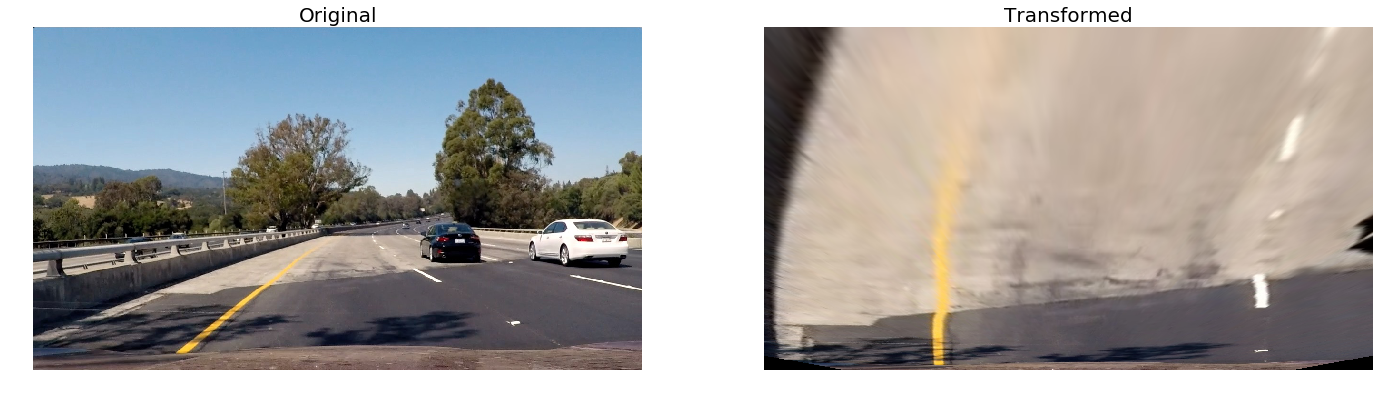

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


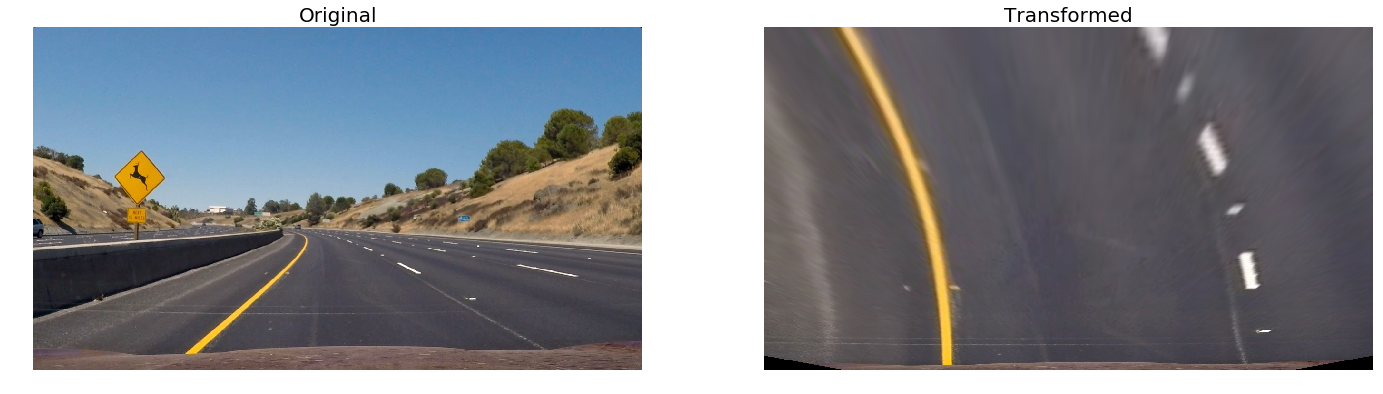

In [10]:
import os
def perspective_transform(image):
    height = image.shape[0]
    width = image.shape[1]
    # Quadrangle verties coordinates in the source image
    s1 = [width // 2 - 76, height * 0.625]
    s2 = [width // 2 + 76, height * 0.625]
    s3 = [-100, height]
    s4 = [width + 100, height]
    src = np.float32([s1, s2, s3, s4])
    # Quadrangle verties coordinates in the destination image
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst = np.float32([d1, d2, d3, d4])
    # Given src and dst points we calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(image, M, (width, height))
    # We also calculate the oposite transform
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix 
    return (warped, unwrap_m)

for image in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image)
    transformed, _ = perspective_transform(image) 
    
    _, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(transformed)
    x2.set_title('Transformed', fontsize=20)

In [24]:
# Detect lane pixels and fit to find the lane boundary.